# Classificação Quântica do Dataset Iris - Com Data Re-uploading

Este notebook implementa um classificador quântico variacional (VQC) para o dataset Iris utilizando a técnica de **Data Re-uploading**, onde os dados são re-encodados em cada camada do circuito quântico.

## Importação das Bibliotecas

In [ ]:
import pennylane as qml
import pennylane.numpy as np
import torch
import torch.nn as nn
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

## Carregamento e Pré-processamento dos Dados

O dataset Iris contém 150 amostras de 3 espécies de flores (Setosa, Versicolor, Virginica), cada uma com 4 features (comprimento e largura de sépalas e pétalas). Os dados são normalizados usando `MinMaxScaler` para adequar ao encoding quântico.

### Configuração do Modelo e Estrutura Quântica
Para o dataset Iris, ainda foi preciso de um circuito mais completo, com mais qubits, layers, nesse notebook eu usei o reupload para treinamento

Por ser um problema multiclasse, resolvi fazer de uma forma diferente o modelo ele é treinado com 3 "classificadores". Na verdade parte do seu peso é treinado especificamente para algum dos resultados, ou seja, o w[1] fica com o primeiro dado, w[2] com o segundo, etc...
Com isso, achei que seria mais facil utilizar o pytoch para treinamento pois ele consegue mapear esses pesos de melhor forma, o que otimizou meu tempo para evitar que escrevesse linhas e linhas de codigos para poder fazer a loss funcionar de forma correta

In [6]:
X,y=load_iris(return_X_y=True)

In [7]:
data = load_iris()
X = data.data
y = data.target

scaler = MinMaxScaler()
scaler.fit(X)
X_norm = scaler.transform(X)

X_torch = torch.tensor(X_norm, dtype=torch.float32, requires_grad=False)
y_torch = torch.tensor(y, dtype=torch.long, requires_grad=False)

In [8]:
X_train, X_val, y_train,y_val = train_test_split(
    X_torch,y_torch,test_size=0.2,random_state=42,shuffle=True
)

## Configuração do Modelo Quântico

Parâmetros do circuito:
- **4 qubits**: Um para cada feature do dataset
- **8 camadas**: Profundidade do circuito variacional
- **3 classes**: Correspondendo às 3 espécies de Iris

Os pesos são organizados em formato `(n_classes, n_layers, n_qubits, 3)` para permitir treinamento separado por classe.

In [9]:
n_qubits = 4
n_layers = 8
n_classes = 3
shape_weights = (n_classes, n_layers, n_qubits, 3)
weights_data = 2 * np.pi * torch.rand(shape_weights)
weights = weights_data.clone().detach().requires_grad_(True)
bias = torch.zeros(n_classes, requires_grad=True)

## Definição do Otimizador e Função de Perda

Utilizamos o otimizador Adam com learning rate de 0.0004 e CrossEntropyLoss para classificação multiclasse.

In [ ]:
opt = torch.optim.Adam([weights, bias], lr=0.0004)
loss_fn = nn.CrossEntropyLoss()

In [10]:
dev = qml.device("default.qubit", wires=n_qubits)

### Circuito Quântico e Estratégia de Embedding
Conforme observado na implementação abaixo, o `AngleEmbedding` é inserido dentro do loop de camadas do circuito.
- **Data Re-uploading:** Ao re-encodar os dados reativamente a cada layer, o modelo ganha maior expressividade e profundidade matemática, facilitando a convergência em fronteiras de decisão não-lineares.

#### Predictor
- Ponto importante desse problema é que no predictor eu passo pelos pesos procurando especificamente a saida deles, com o conjunto de 3 saidas eu pego a maior e digo como resposta ela

In [11]:
def layer(weights_da_camada):
    w_expandido = qml.math.expand_dims(weights_da_camada, 0)
    qml.StronglyEntanglingLayers(weights=w_expandido, wires=range(n_qubits))

@qml.qnode(dev,interface="torch")
def circuito(weights, x):
    for i, layer_w in enumerate(weights):
        qml.AngleEmbedding(features=x, wires=range(n_qubits), rotation="Z")
        layer(layer_w,)

    return qml.expval(qml.PauliZ(0) )


def predictor(weights, bias, x):
    res = []
    for i in range(3):
        output = circuito(weights[i], x) + bias[i]
        res.append(output)

    return torch.stack(res).t()

# Visualização do circuito

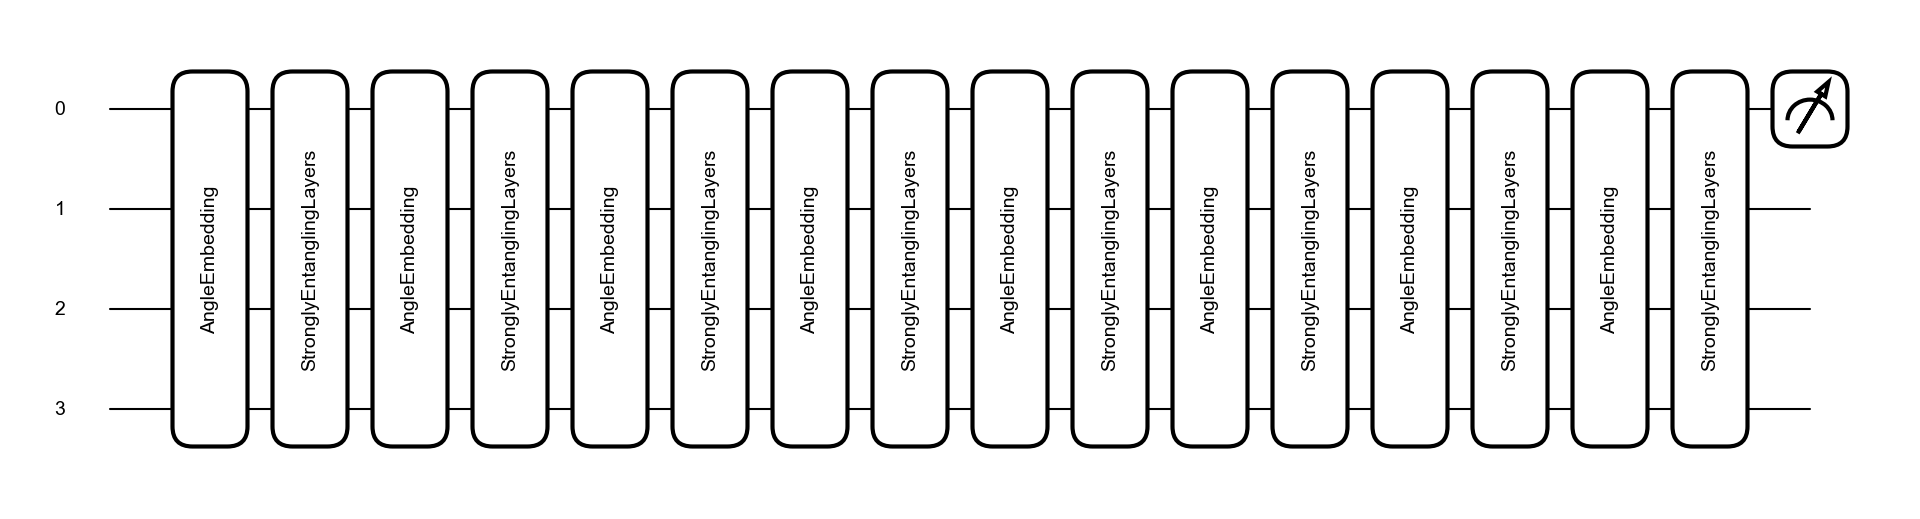

In [12]:
w_sample = weights[0]
x_sample = X_train[0]

fig, ax = qml.draw_mpl(circuito, decimals=2)(w_sample, x_sample)
plt.show()

# Treino

Treinando: 100%|██████████| 5000/5000 [14:45<00:00,  5.64it/s, acc=0.9533, loss=0.4064]


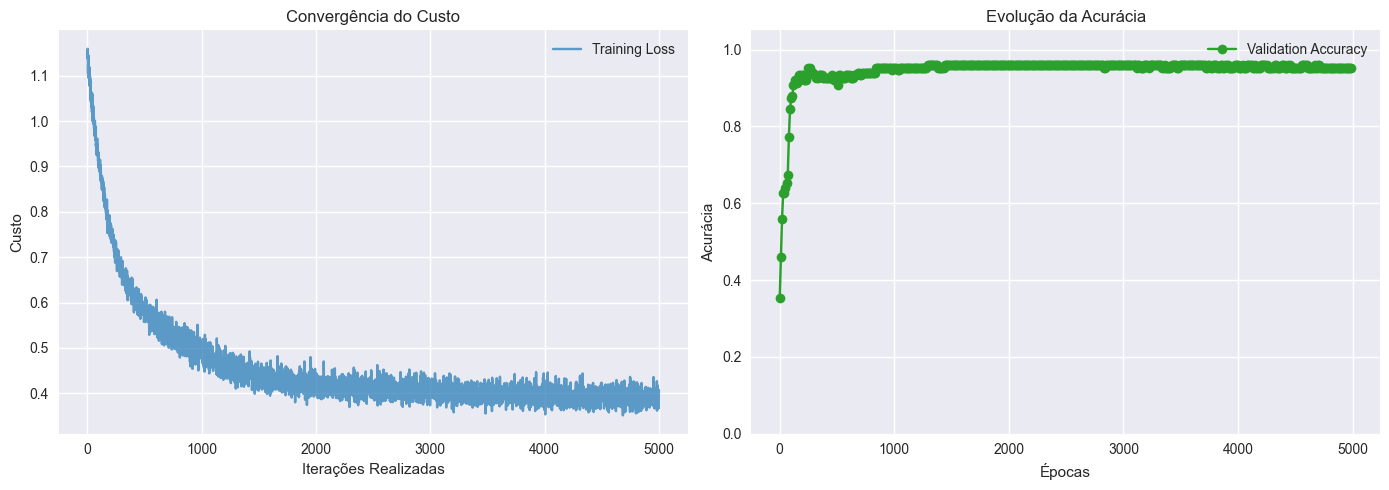

In [ ]:
loss_history = []
acc_history = []
epochs_x = []

epochs = 5000
batch_size = 120

X_val_torch = X_val.clone().detach().to(torch.float32)
y_val_torch = y_val.clone().detach().to(torch.long)
X_train_torch = X_train.clone().detach().to(torch.float32)
y_train_torch = y_train.clone().detach().to(torch.long)

pbar = tqdm(range(epochs), desc="Treinando")

for it in pbar:
    opt.zero_grad()

    batch_index = torch.randint(0, len(X_train_torch), (batch_size,))
    X_batch = X_train_torch[batch_index]
    y_batch = y_train_torch[batch_index]

    outputs = predictor(weights, bias, X_batch)
    loss = loss_fn(outputs, y_batch)
    loss.backward()
    opt.step()

    loss_history.append(loss.item())

    if it % 10 == 0:
        with torch.no_grad():
            outputs_val = predictor(weights, bias, X_torch)
            predictions = torch.argmax(outputs_val, dim=1)
            correct = (predictions == y_torch).float().sum()
            current_acc = correct / len(y_torch)

            acc_history.append(current_acc.item())
            epochs_x.append(it)
            last_acc = current_acc.item()

    pbar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{last_acc:.4f}")

pbar.close()

plt.style.use('seaborn-v0_8')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(range(len(loss_history)), loss_history, label='Training Loss', color='tab:blue', alpha=0.7)
ax1.set_title('Convergência do Custo')
ax1.set_xlabel('Iterações Realizadas') # Texto ajustado
ax1.set_ylabel('Custo')
ax1.grid(True)
ax1.legend()

ax2.plot(epochs_x, acc_history, label='Validation Accuracy', color='tab:green', marker='o', linestyle='-')
ax2.set_title('Evolução da Acurácia')
ax2.set_xlabel('Épocas')
ax2.set_ylabel('Acurácia')
ax2.set_ylim(0, 1.05)
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
def val(xx,yy):
    class_names = ["Setosa (0)", "Versicolor (1)", "Virginica (2)"]

    print("\n--- INICIANDO VALIDAÇÃO ---\n")
    with torch.no_grad():
        logits = predictor(weights, bias, xx)

        predictions = torch.argmax(logits, dim=1)

    results = []
    correct_count = 0

    print(f"{'ID':<5} | {'Real':<15} | {'Predito':<15} | {'Status'}")
    print("-" * 50)

    for i in range(len(yy)):
        real_idx = yy[i].item()
        pred_idx = predictions[i].item()

        is_correct = real_idx == pred_idx
        if is_correct:
            correct_count += 1
            status = "OK"
        else:
            status = "ERRO"

        print(f"{i:<5} | {class_names[real_idx]:<15} | {class_names[pred_idx]:<15} | {status}")

        results.append({
            "Real": real_idx,
            "Predito": pred_idx,
            "Correto": is_correct
        })

    final_acc = correct_count / len(yy)
    print("-" * 50)
    print(f"Total de Amostras: {len(yy)}")
    print(f"Acertos: {correct_count}")
    print(f"Acurácia Final: {final_acc:.2%}")

    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(y_torch.numpy(), predictions.numpy())

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.title('Matriz de Confusão')
    plt.show()

## Validação e Matriz de Confusão

Função para avaliar o modelo e visualizar os resultados através da matriz de confusão.


--- INICIANDO VALIDAÇÃO ---

ID    | Real            | Predito         | Status
--------------------------------------------------
0     | Setosa (0)      | Setosa (0)      | OK
1     | Setosa (0)      | Setosa (0)      | OK
2     | Setosa (0)      | Setosa (0)      | OK
3     | Setosa (0)      | Setosa (0)      | OK
4     | Setosa (0)      | Setosa (0)      | OK
5     | Setosa (0)      | Setosa (0)      | OK
6     | Setosa (0)      | Setosa (0)      | OK
7     | Setosa (0)      | Setosa (0)      | OK
8     | Setosa (0)      | Setosa (0)      | OK
9     | Setosa (0)      | Setosa (0)      | OK
10    | Setosa (0)      | Setosa (0)      | OK
11    | Setosa (0)      | Setosa (0)      | OK
12    | Setosa (0)      | Setosa (0)      | OK
13    | Setosa (0)      | Setosa (0)      | OK
14    | Setosa (0)      | Setosa (0)      | OK
15    | Setosa (0)      | Setosa (0)      | OK
16    | Setosa (0)      | Setosa (0)      | OK
17    | Setosa (0)      | Setosa (0)      | OK
18    | Setosa (0)    

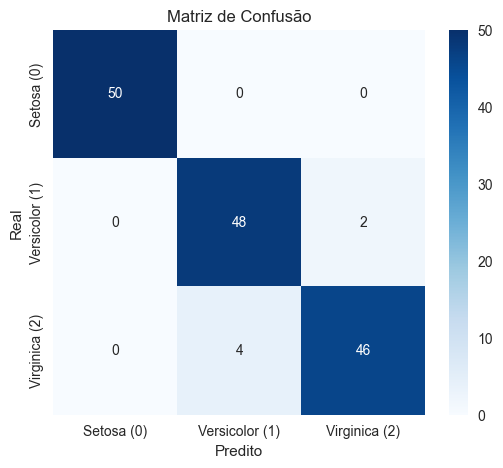

In [16]:
val(X_torch, y_torch)

### Validação no Dataset Completo

In [17]:
val(X_val_torch,y_val_torch)


--- INICIANDO VALIDAÇÃO ---

ID    | Real            | Predito         | Status
--------------------------------------------------
0     | Versicolor (1)  | Versicolor (1)  | OK
1     | Setosa (0)      | Setosa (0)      | OK
2     | Virginica (2)   | Virginica (2)   | OK
3     | Versicolor (1)  | Versicolor (1)  | OK
4     | Versicolor (1)  | Versicolor (1)  | OK
5     | Setosa (0)      | Setosa (0)      | OK
6     | Versicolor (1)  | Versicolor (1)  | OK
7     | Virginica (2)   | Virginica (2)   | OK
8     | Versicolor (1)  | Versicolor (1)  | OK
9     | Versicolor (1)  | Versicolor (1)  | OK
10    | Virginica (2)   | Virginica (2)   | OK
11    | Setosa (0)      | Setosa (0)      | OK
12    | Setosa (0)      | Setosa (0)      | OK
13    | Setosa (0)      | Setosa (0)      | OK
14    | Setosa (0)      | Setosa (0)      | OK
15    | Versicolor (1)  | Versicolor (1)  | OK
16    | Virginica (2)   | Virginica (2)   | OK
17    | Versicolor (1)  | Versicolor (1)  | OK
18    | Versicolor (1)

ValueError: Found input variables with inconsistent numbers of samples: [150, 30, 150]

<Figure size 600x500 with 0 Axes>

### Validação no Conjunto de Teste

Avaliação apenas nos dados de teste (20% do dataset) que não foram vistos durante o treinamento.